In [1]:
import numpy as np
import pandas as pd
import warnings
import shap
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/ziqili/Desktop/geoshapley-main/geoshapley')

In [3]:
from geoshapley import GeoShapleyExplainer

In [4]:
size=25
def plot_s(bs,vmin=None,vmax=None, title = ""):
    k = len(bs)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=300)
    for i in range(k):
        ax = axs[i].imshow(bs[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax)
        
        fig.colorbar(ax, ax=axs[i])

        axs[i].set_xticks(np.arange(-0.5, size, 5))
        axs[i].set_yticks(np.arange(-0.5, size, 5))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
    fig.suptitle(title, fontsize=20,y=1.05)

In [5]:
mgwr_sim = pd.read_csv("../data/mgwr_sim.csv")

In [6]:
X_coords = mgwr_sim[['X1','X2','x_coord','y_coord']]
y = mgwr_sim.y.values

true = mgwr_sim[["b0","b1","b2"]].values

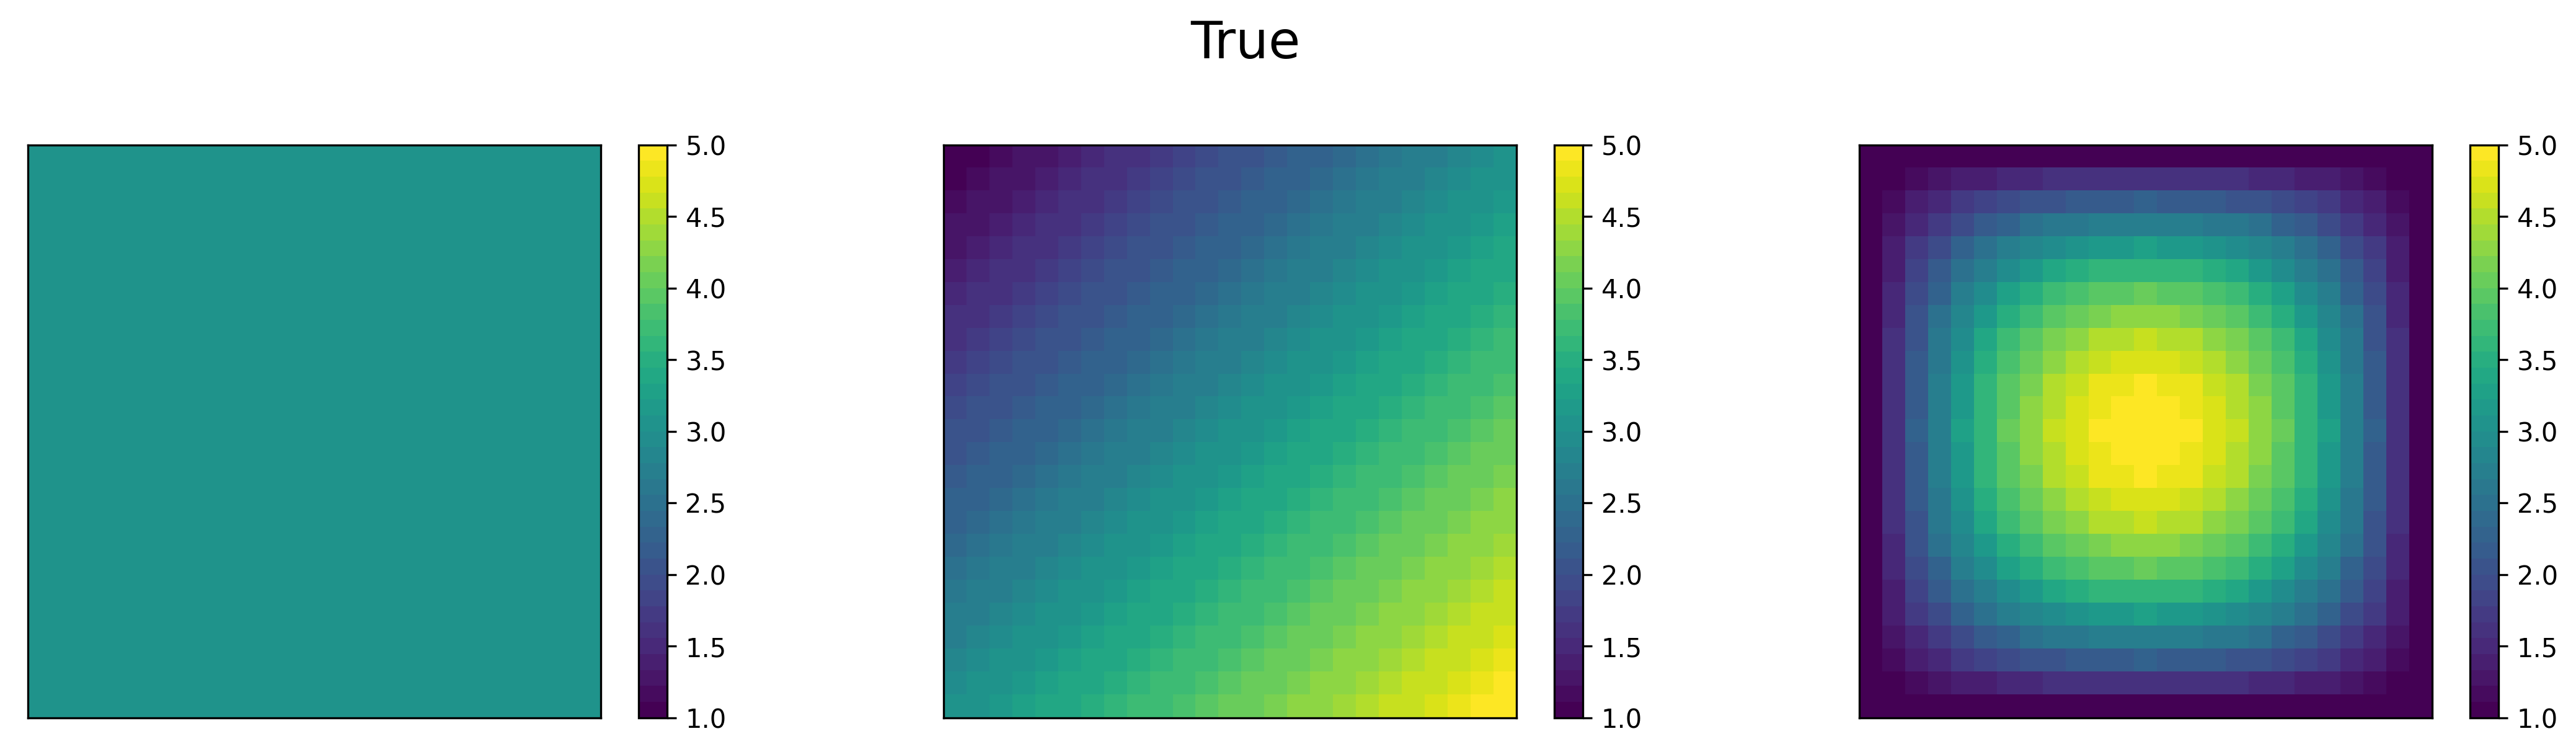

In [7]:
warnings.filterwarnings('ignore')
plot_s(true.T,vmin=1,vmax=5,title = "True")

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_coords, y,random_state=1)

In [9]:
from hpsklearn import HyperoptEstimator, random_forest_regressor,mlp_regressor,svr
from hpsklearn import xgboost_regression,gaussian_process_regressor,linear_regression
from hyperopt import tpe

In [10]:
def train_any_model(any_regressor,max_evals=10):
    estim = HyperoptEstimator(regressor=any_regressor("myModel"),
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=60)
    estim.fit(X_train, y_train)
    return estim

In [11]:
%%time
for i in range(0,200):
    try:
        mlp_model = train_any_model(mlp_regressor)
        break
    except:
        pass

 50%|███████████████████▌                   | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (223) reached and the optimization hasn't converged yet.
  warnings.warn(


 67%|██████████████████████████             | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (235) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 10/10 [00:01<00:00,  1.11s/trial, best loss: 0.00678242703590104]
CPU times: user 1.1 s, sys: 219 ms, total: 1.32 s
Wall time: 12.3 s


In [12]:
%%time
xgb_model = train_any_model(xgboost_regression)

100%|█████████| 10/10 [00:01<00:00,  1.34s/trial, best loss: 0.035395270914628574]
CPU times: user 1.12 s, sys: 1.68 s, total: 2.8 s
Wall time: 13.7 s


In [13]:
background_X = X_coords.values

In [14]:
mlp_explainer = GeoShapleyExplainer(mlp_model.predict, background_X)

mlp_rslt = mlp_explainer.explain(X_coords)

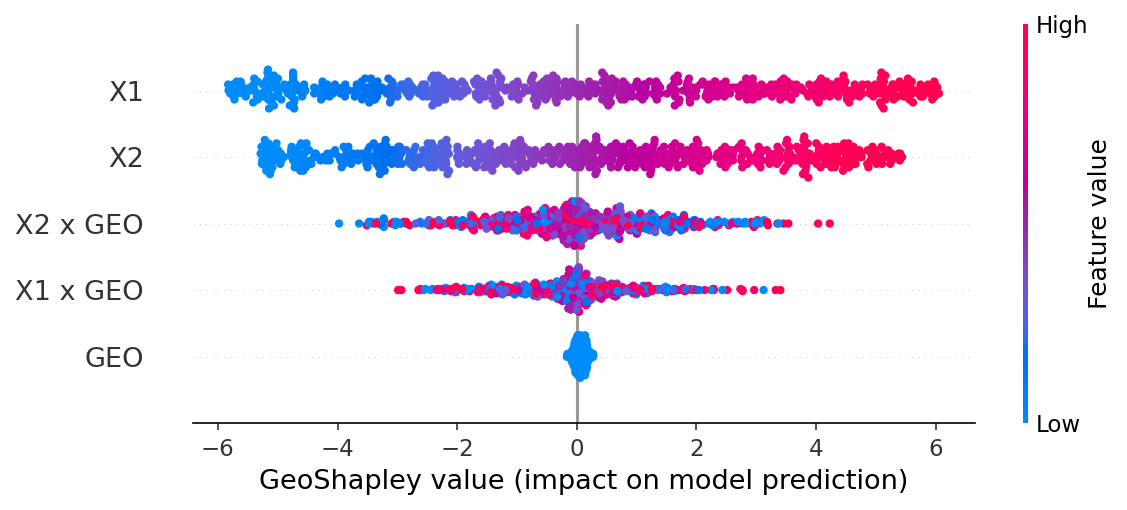

In [15]:
mlp_rslt.summary_plot(dpi=150)

In [16]:
xgb_explainer = GeoShapleyExplainer(xgb_model.predict, background_X)

xgb_rslt = xgb_explainer.explain(X_coords)

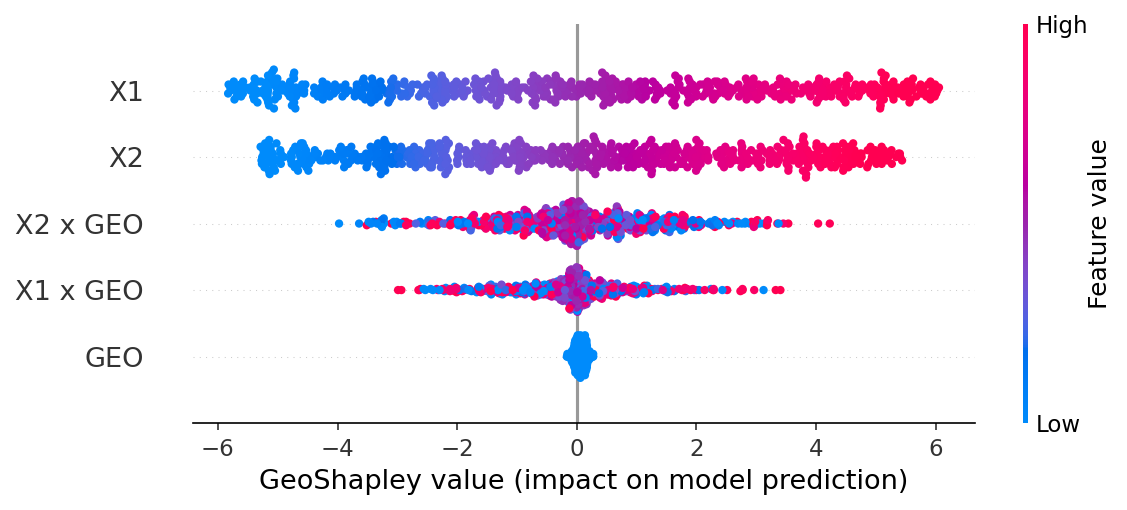

In [17]:
mlp_rslt.summary_plot(dpi=150)

In [18]:
xgb_explainer.X_geo

,X1,X2,x_coord,y_coord
0,0.136931,-1.896889,-12.0,-12.0
1,0.774086,1.559803,-11.0,-12.0
2,1.375514,-1.919209,-10.0,-12.0
3,0.647878,0.269916,-9.0,-12.0
4,-1.819095,0.082955,-8.0,-12.0
...,...,...,...,...
620,-1.048481,1.382871,8.0,12.0
621,-0.800792,-1.935607,9.0,12.0
622,1.934044,1.210230,10.0,12.0
623,1.511441,0.193201,11.0,12.0


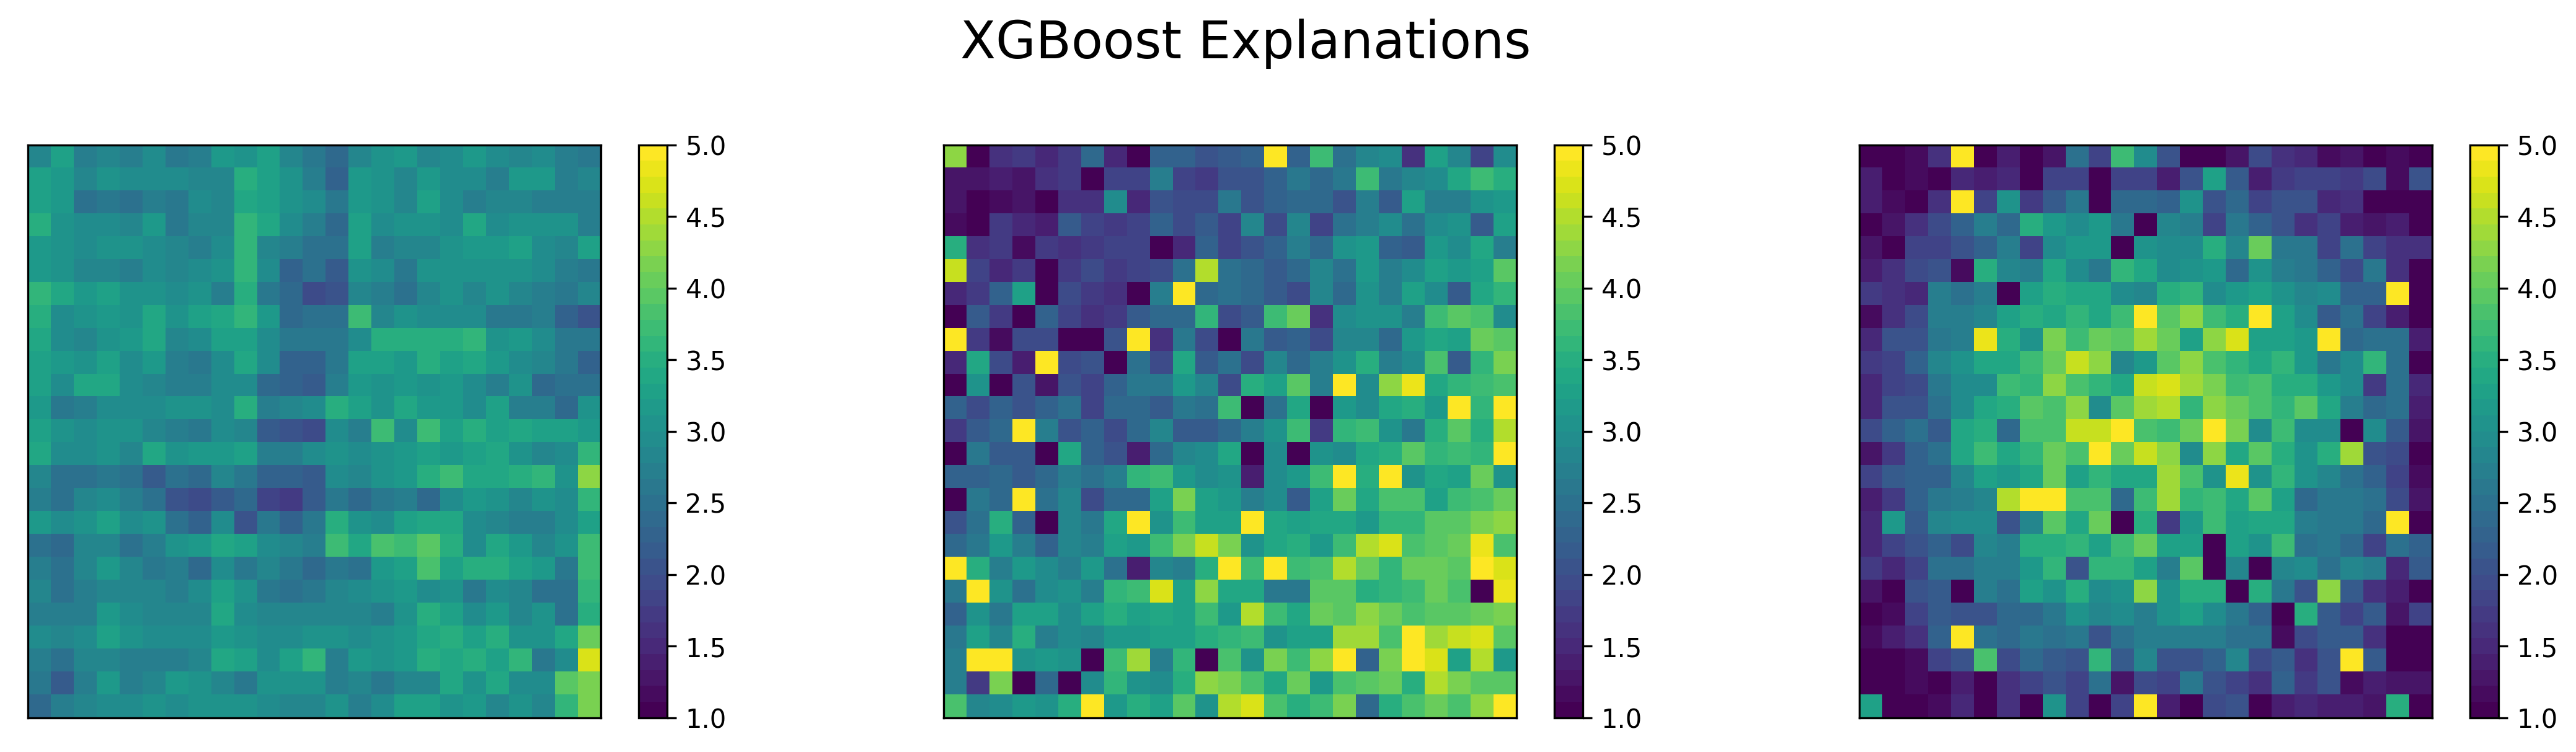

In [20]:
xgb_svc = xgb_rslt.get_svc(col = [0, 1])

plot_s(xgb_svc.T,vmin=1,vmax=5,title="XGBoost Explanations")

In [21]:
mlp_svc = mlp_rslt.get_svc(col = [0, 1])

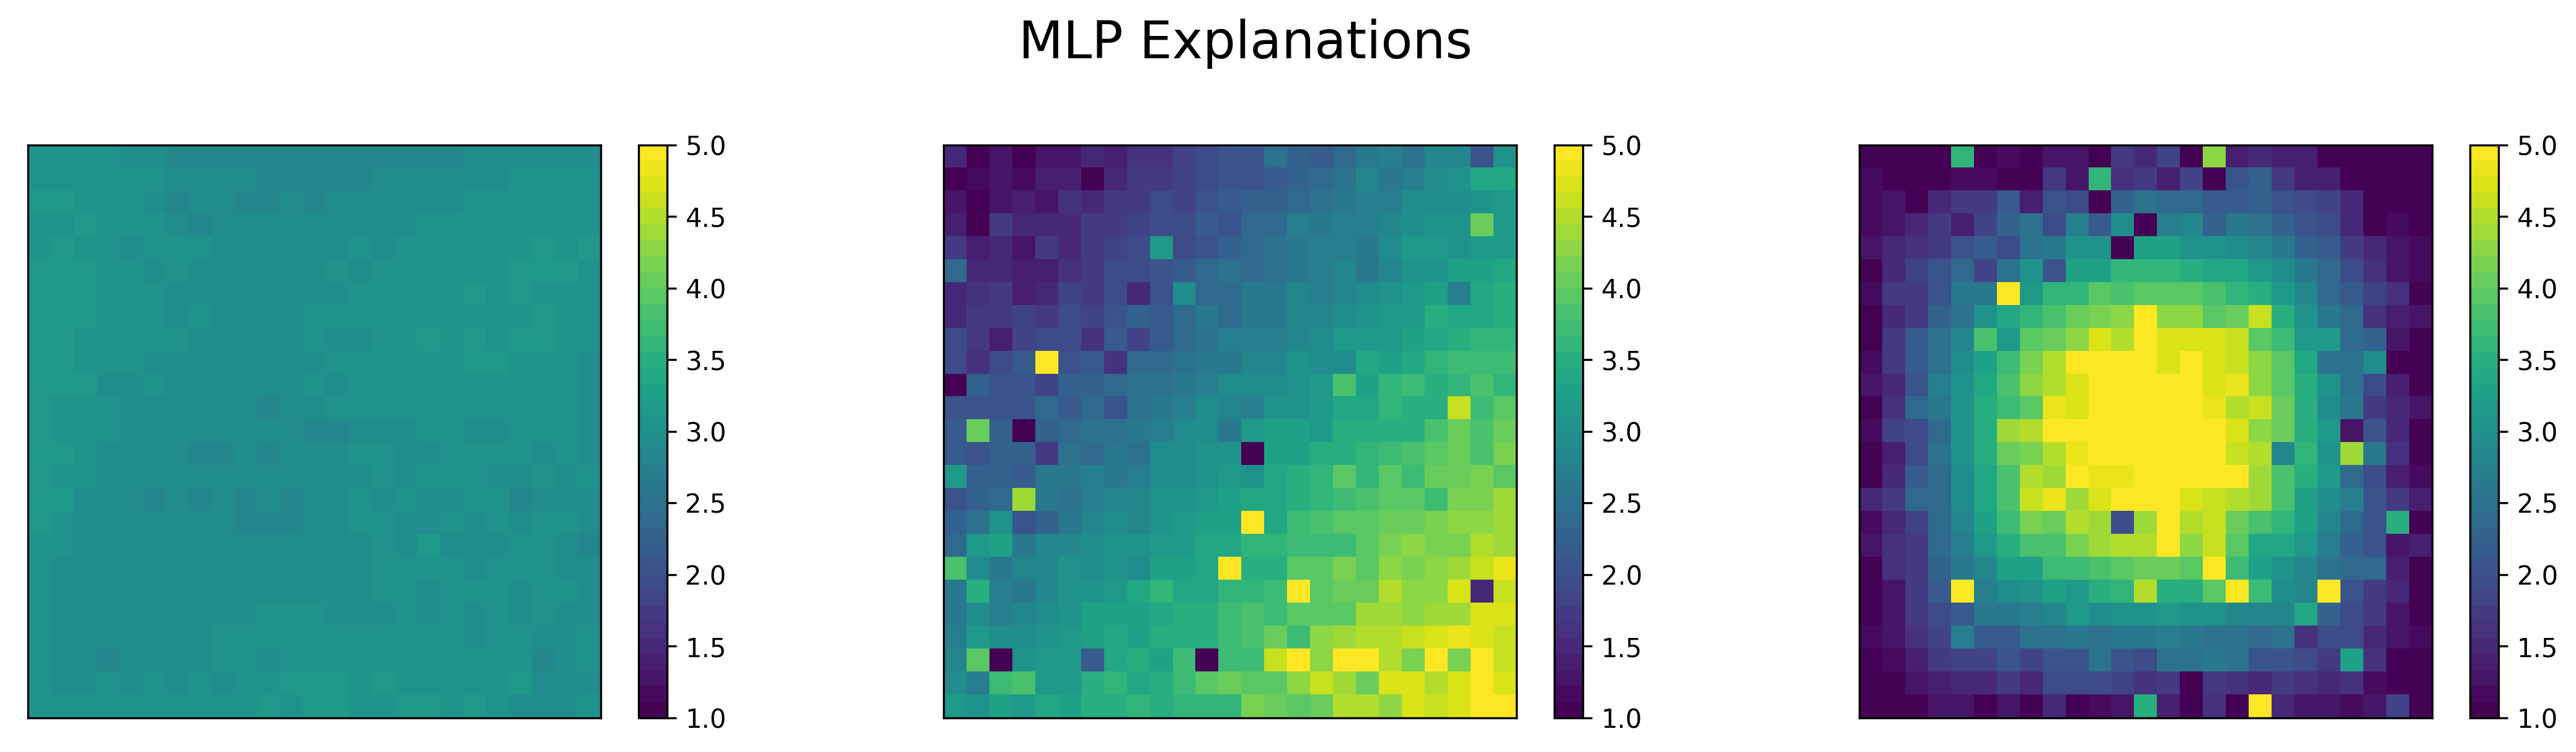

In [22]:
plot_s(mlp_svc.T,vmin=1,vmax=5,title="MLP Explanations")

In [23]:
import sys
sys.path.append('/Users/ziqili/Desktop/mgwr-git')
sys.path.append('/Users/ziqili/Desktop/spglm-master')

from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [25]:
sel = Sel_BW(X_coords.values[:,-2:],y.reshape(-1,1),X_coords.values[:,:-2],multi=True)
sel.search()
mgwr_rslt = MGWR(X_coords.values[:,-2:],y.reshape(-1,1),X_coords.values[:,:-2],selector=sel).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

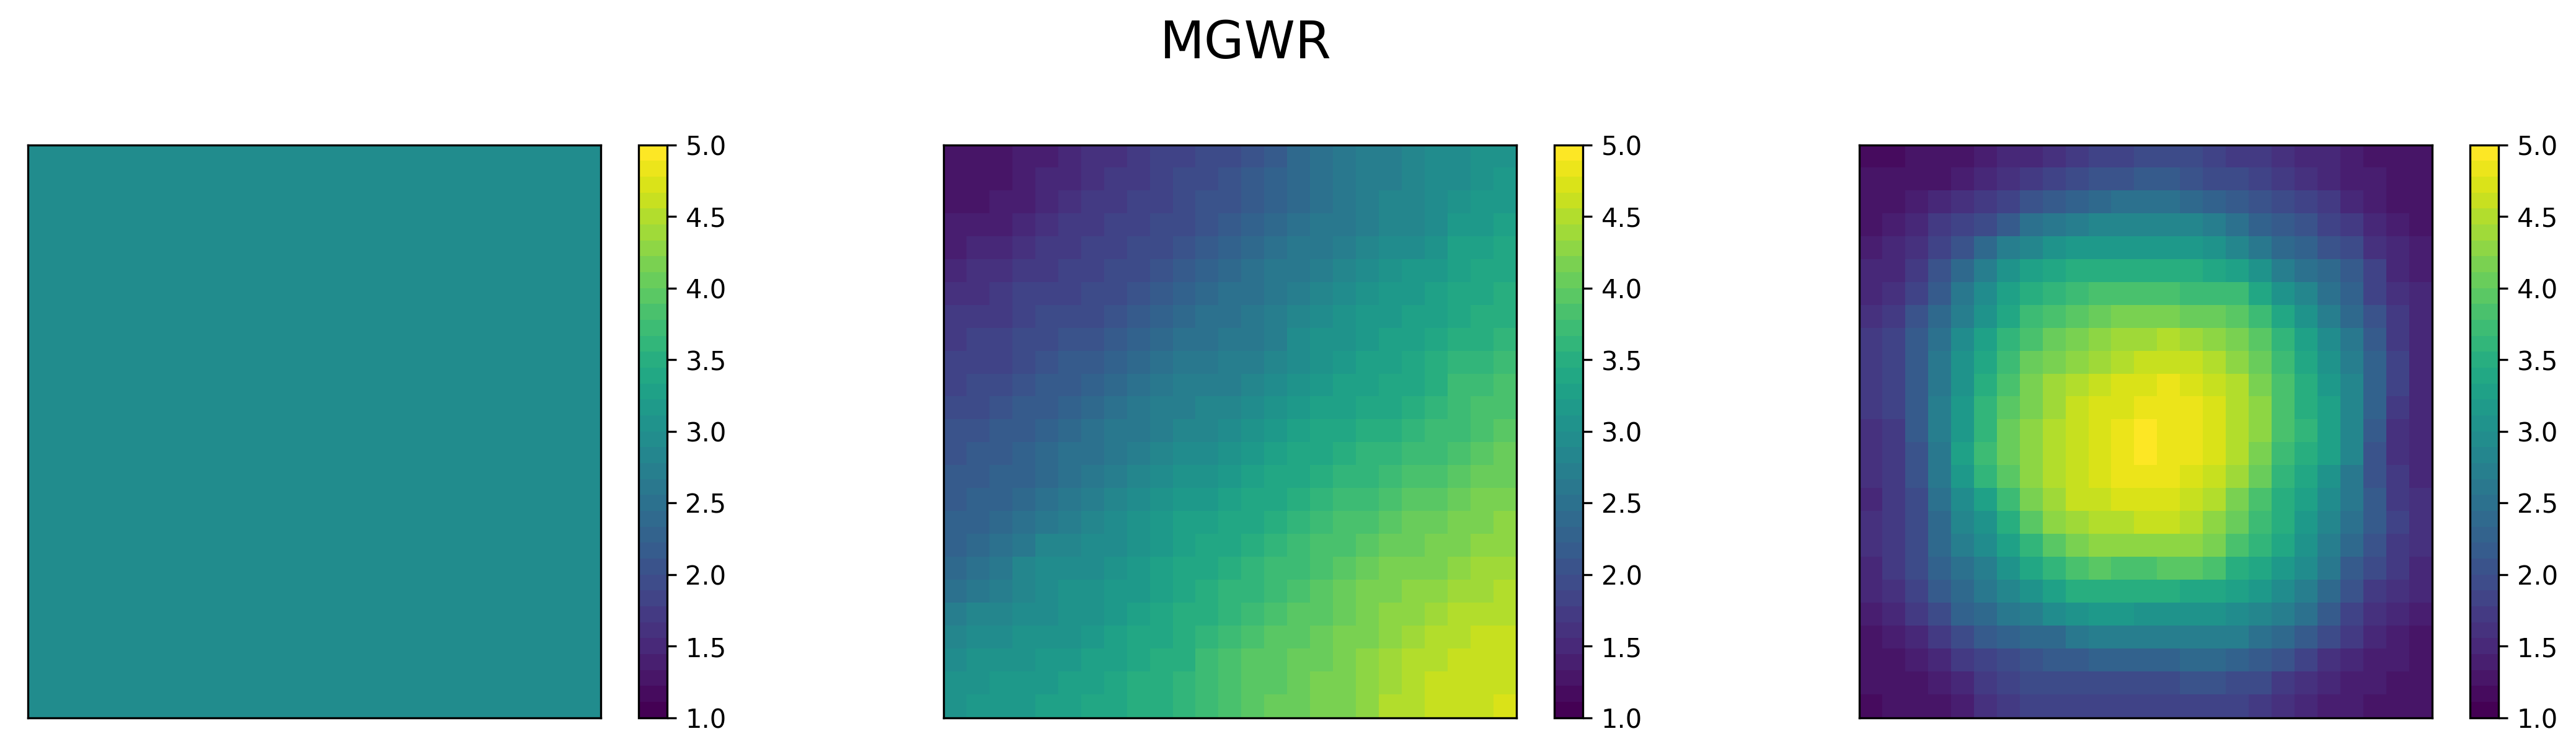

In [26]:
plot_s(mgwr_rslt.params.T,vmin=1,vmax=5,title="MGWR")